# Quantum Bayesian Inference with Qiskit

##### Exact inference on Bayesian networks is \#P-hard. That is why usually approximate inference is used to sample from the distribution on query variables given evidence variables. Quantum Bayesian Inference provides a method to speed up the sampling process. By employing a quantum version of rejection sampling and leveraging amplitude amplification, quantum computation achieves a significant speedup, making it possible to obtain samples much faster. This method efficiently utilizes the structure of Bayesian networks to produce quantum states that represent classical probability distributions. 

##### This tutorial will guide you through the process of using the QBayesian class to perform such inference tasks. This inference algorithm implements the algorithm from the paper "Quantum inference on Bayesian networks" by Low, Guang Hao et al. This leads to a speedup per sample from $O(nmP(e)^{-1})$ to $O(n2^{m}P(e)^{-\frac{1}{2}})$, where n is the number of nodes in the Bayesian network with at most m parents per node and e the evidence.



# Step 1: Creating Rotations for Bayesian Network

In the first example we consider a simple Bayesian network that is only based on two nodes.

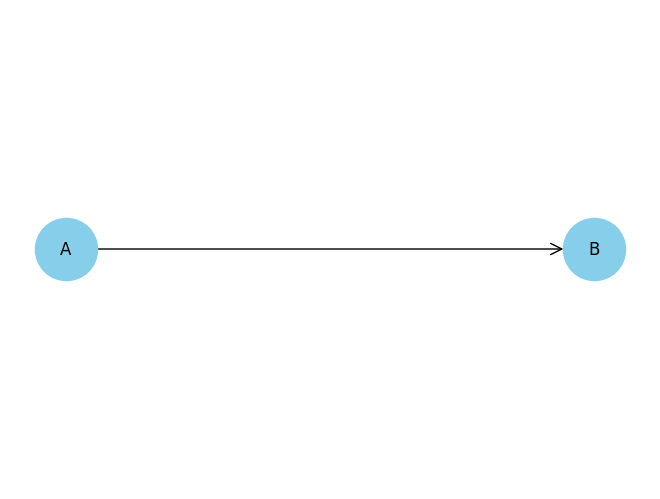

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
# Create a directed graph
G = nx.DiGraph()
# Add nodes. The nodes will be positioned at (0, 0) and (1, 0) respectively.
G.add_node('A', pos=(0, 0))
G.add_node('B', pos=(1, 0))
# Add a directed edge from A to B
G.add_edge('A', 'B')
# Get the positions of each node
pos = nx.get_node_attributes(G, 'pos')
# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', arrowstyle='->', arrowsize=20)
# Show the plot
plt.show()

For the quantum circuit we need rotation angles that represent the conditional probability tables. For example:
$$P(A)=0.2$$
$$P(B|A)=0.9$$
$$P(B|-A)=0.3$$

In [2]:
# Include libraries
import numpy as np
# Define rotation angles
theta_A = 2 * np.arcsin(np.sqrt(0.2))
theta_B_A = 2 * np.arcsin(np.sqrt(0.9))
theta_B_nA = 2 * np.arcsin(np.sqrt(0.3))

# Step 2: Create a Quantum Circuit for Bayesian Network

A Bayesian network can be represented as a quantum circuit where each node is a qubit, and the edges are quantum gates that represent the conditional dependencies.

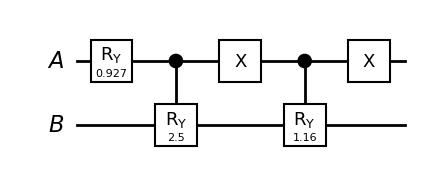

In [3]:
from qiskit import QuantumRegister
from qiskit import QuantumCircuit
# Define quantum registers 
qrA = QuantumRegister(1, name='A')
qrB = QuantumRegister(1, name='B')
# Define a 2-qubit quantum circuit
qc = QuantumCircuit(qrA, qrB, name="Bayes net small")
#Apply the R_Y_theta rotation gate on the first qubit
qc.ry(theta_A, 0)
# Apply the controlled-R_Y_theta rotation gate
qc.cry(theta_B_A, control_qubit=qrA, target_qubit=qrB)
# Apply the X gate on the first qubit
qc.x(0)
# Apply the controlled-R_Y_theta rotation gate
qc.cry(theta_B_nA, control_qubit=qrA, target_qubit=qrB)
# Apply another X gate on the first qubit
qc.x(0)
qc.draw('mpl', style='bw', plot_barriers=False, justify='none', fold=-1)

# Step 3: Perform Inference

To use the `QBayesian` class, instantiate it with a quantum circuit that represents the Bayesian network. You can then use the `inference` method to estimate probabilities given evidence.

In [4]:
from qiskit_machine_learning.algorithms .inference import QBayesian

query = {'B': 0}
evidence = {'A': 1}
# Initialize quantum bayesian inference framework
qbayesian = QBayesian(circuit=qc)
# Inference
qbayesian.inference(query=query, evidence=evidence)

0.11777

# Step 4: Generalize the approach for n nodes

Now we generalize the approach for n nodes in a chain with random probabilities.

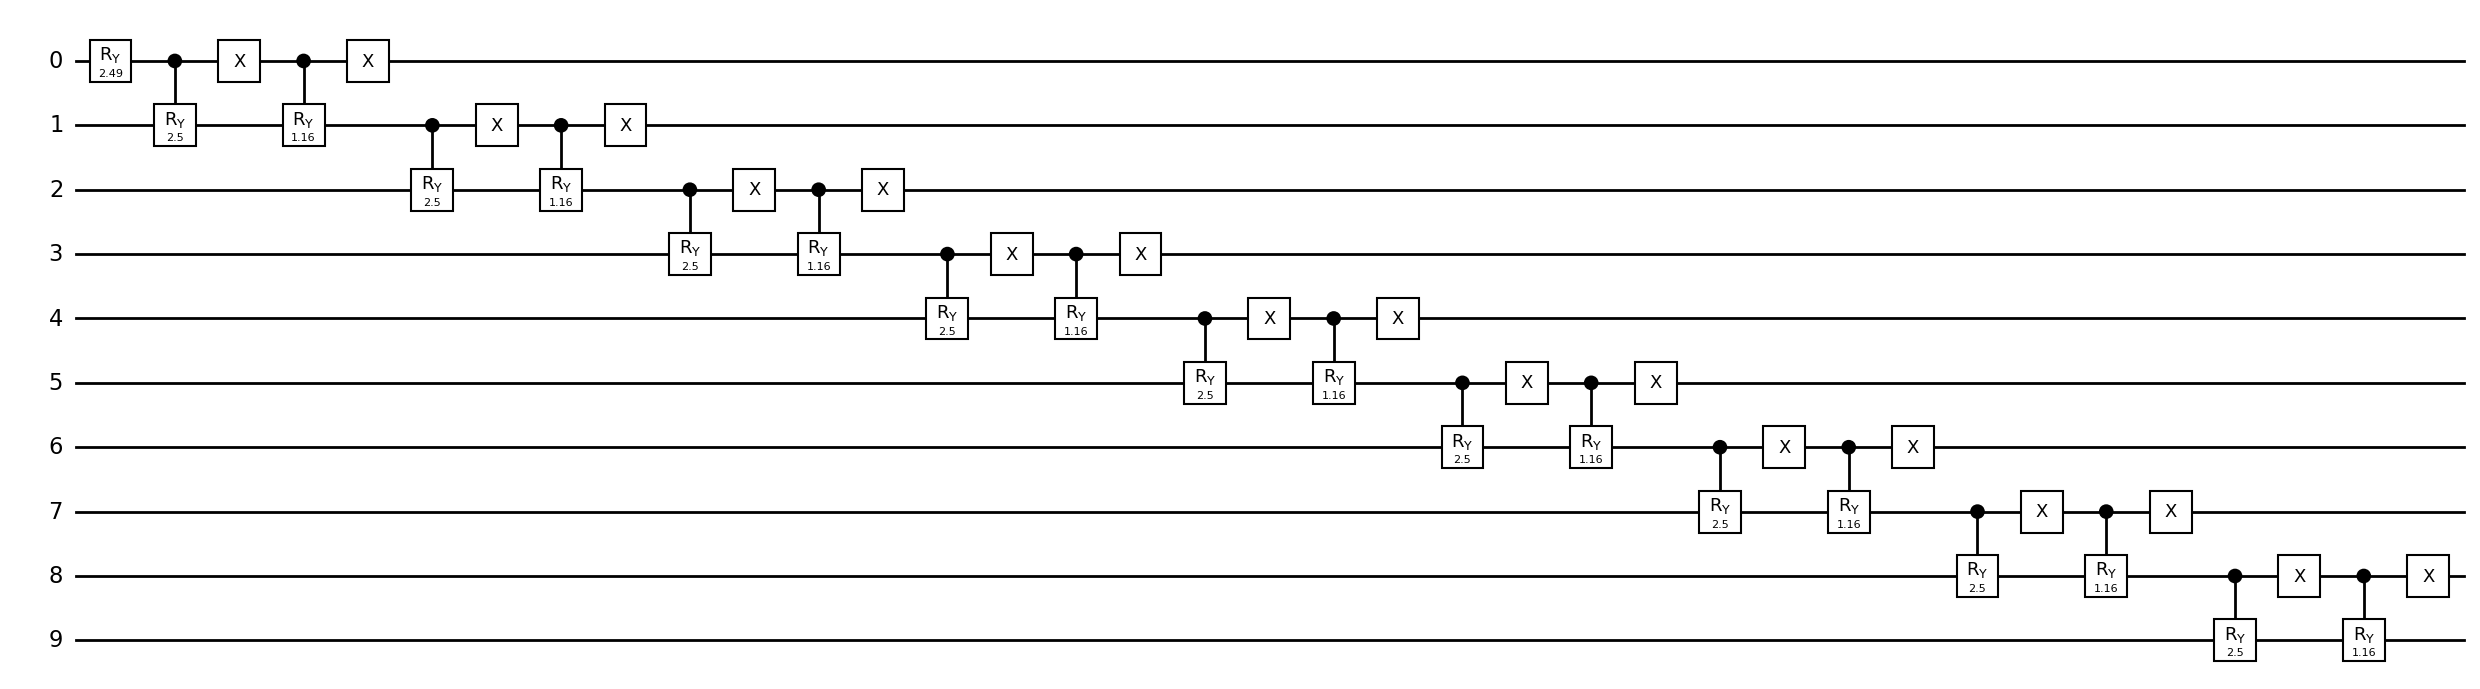

In [5]:
# Choose the number of nodes
n = 10 
# Generate probabilities
prob = np.random.random_sample(2*(n-1)+1)
theta = [2 * np.arcsin(np.sqrt(p)) for p in prob]
# Define quantum registers 
qr = [QuantumRegister(1, name=i) for i in range(n)]
# Generate circuit
qc = QuantumCircuit(*qr, name="Bayes net")
#Apply the R_Y_theta rotation gate on the first qubit
qc.ry(theta[0], 0)
# Apply the controlled-R_Y_theta rotations
for i in range(1, n, 1):
    qc.cry(theta_B_A, control_qubit=i-1, target_qubit=i)
    qc.x(i-1)
    qc.cry(theta_B_nA, control_qubit=i-1, target_qubit=i)
    qc.x(i-1)
# Draw circuit
qc.draw('mpl', style='bw', plot_barriers=False, justify='none', fold=-1)

We could also do inference with this model, but the chosen probabilities are random, as is the result.

{'1000000000': 0.33117, '0000000000': 0.66883}


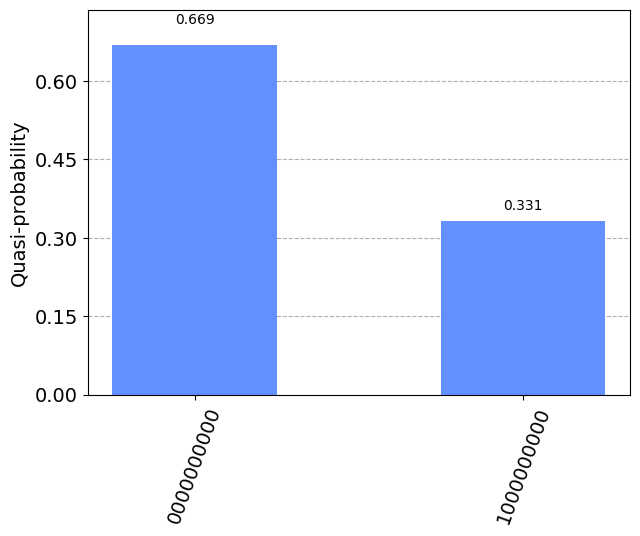

In [6]:
from qiskit.visualization import plot_histogram

evidence = {str(i): 0 for i in range(n-1)}
# Initialize quantum bayesian
qbayesian = QBayesian(circuit=qc)
# Inference
samples = qbayesian.rejection_sampling(evidence=evidence)
print(samples)
plot_histogram(samples)

# Step 5: Pachinko 

Pachinko is a popular Japanese game that combines elements of pinball and slot machines. Players purchase steel balls, launch them into a playfield filled with pins, and aim to land them in specific pockets. Let us now consider a pachinko game for 15 pins, in which a ball goes to the left or right of the pin with a probability of 0.5 in each case. You can use the following code to plot the Pachinko game.

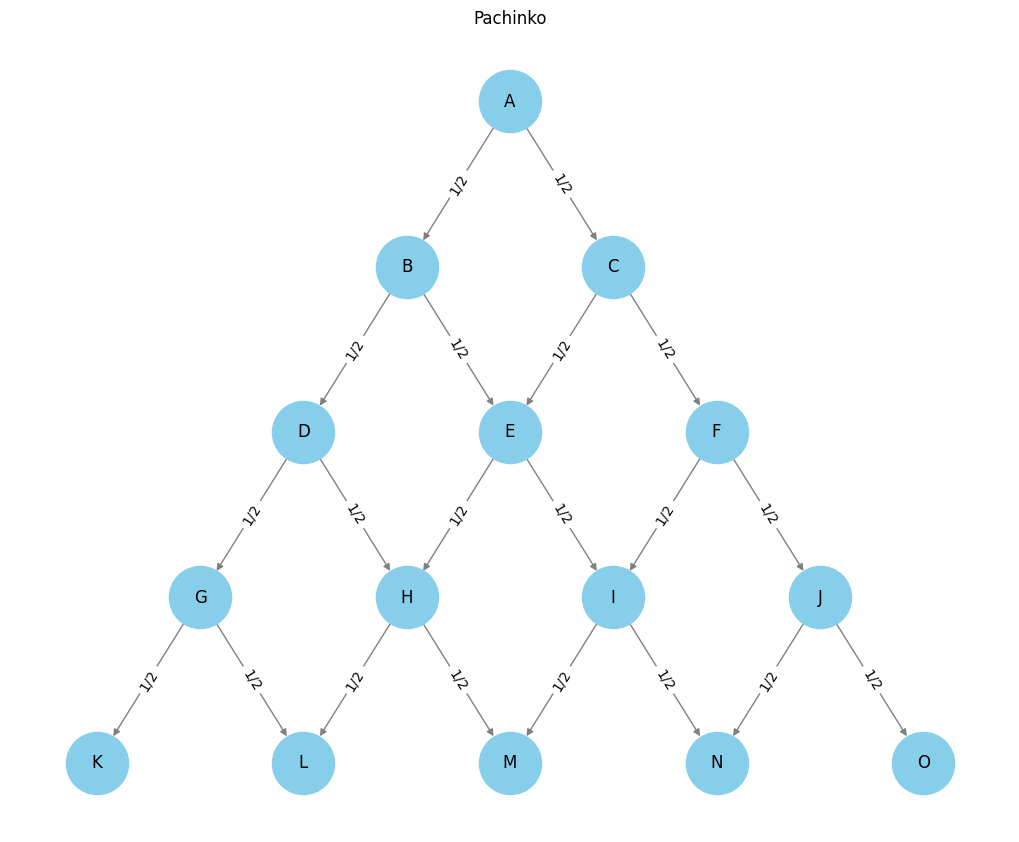

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a new graph
G = nx.DiGraph()

# Add nodes with their positions
positions = {'A': (2, -1), 'B': (1, -2.5), 'C': (3, -2.5),
             'D': (0, -4), 'E': (2, -4), 'F': (4, -4),
             'G': (-1, -5.5), 'H': (1, -5.5), 'I': (3, -5.5), 'J': (5, -5.5),
             'K': (-2, -7), 'L': (0, -7), 'M': (2, -7), 'N': (4, -7), 'O': (6, -7)}

for node, pos in positions.items():
    G.add_node(node, pos=pos)

# Add edges with labels
edges = [('A', 'B', '1/2'), ('A', 'C', '1/2'),
         ('B', 'D', '1/2'), ('B', 'E', '1/2'), 
         ('C', 'E', '1/2'), ('C', 'F', '1/2'),
         ('D', 'G', '1/2'), ('D', 'H', '1/2'),
         ('E', 'H', '1/2'), ('E', 'I', '1/2'),
         ('F', 'I', '1/2'), ('F', 'J', '1/2'),
         ('G', 'K', '1/2'), ('G', 'L', '1/2'),
         ('H', 'L', '1/2'), ('H', 'M', '1/2'),
         ('I', 'M', '1/2'), ('I', 'N', '1/2'),
         ('J', 'N', '1/2'), ('J', 'O', '1/2')]

for u, v, weight in edges:
    G.add_edge(u, v, weight=weight)

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(G, pos=positions, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos=positions, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)})

plt.title("Pachinko")
plt.show()


To convert the Pachinko game into a quantum circuit, no negation of the variables is required, since: $P(X)=0.5=1-P(X)=P(-X)$.

[1, 2, 3, 4, 4, 5, 6, 7, 7, 8, 8, 9, 10, 11, 11, 12, 12, 13, 13, 14]


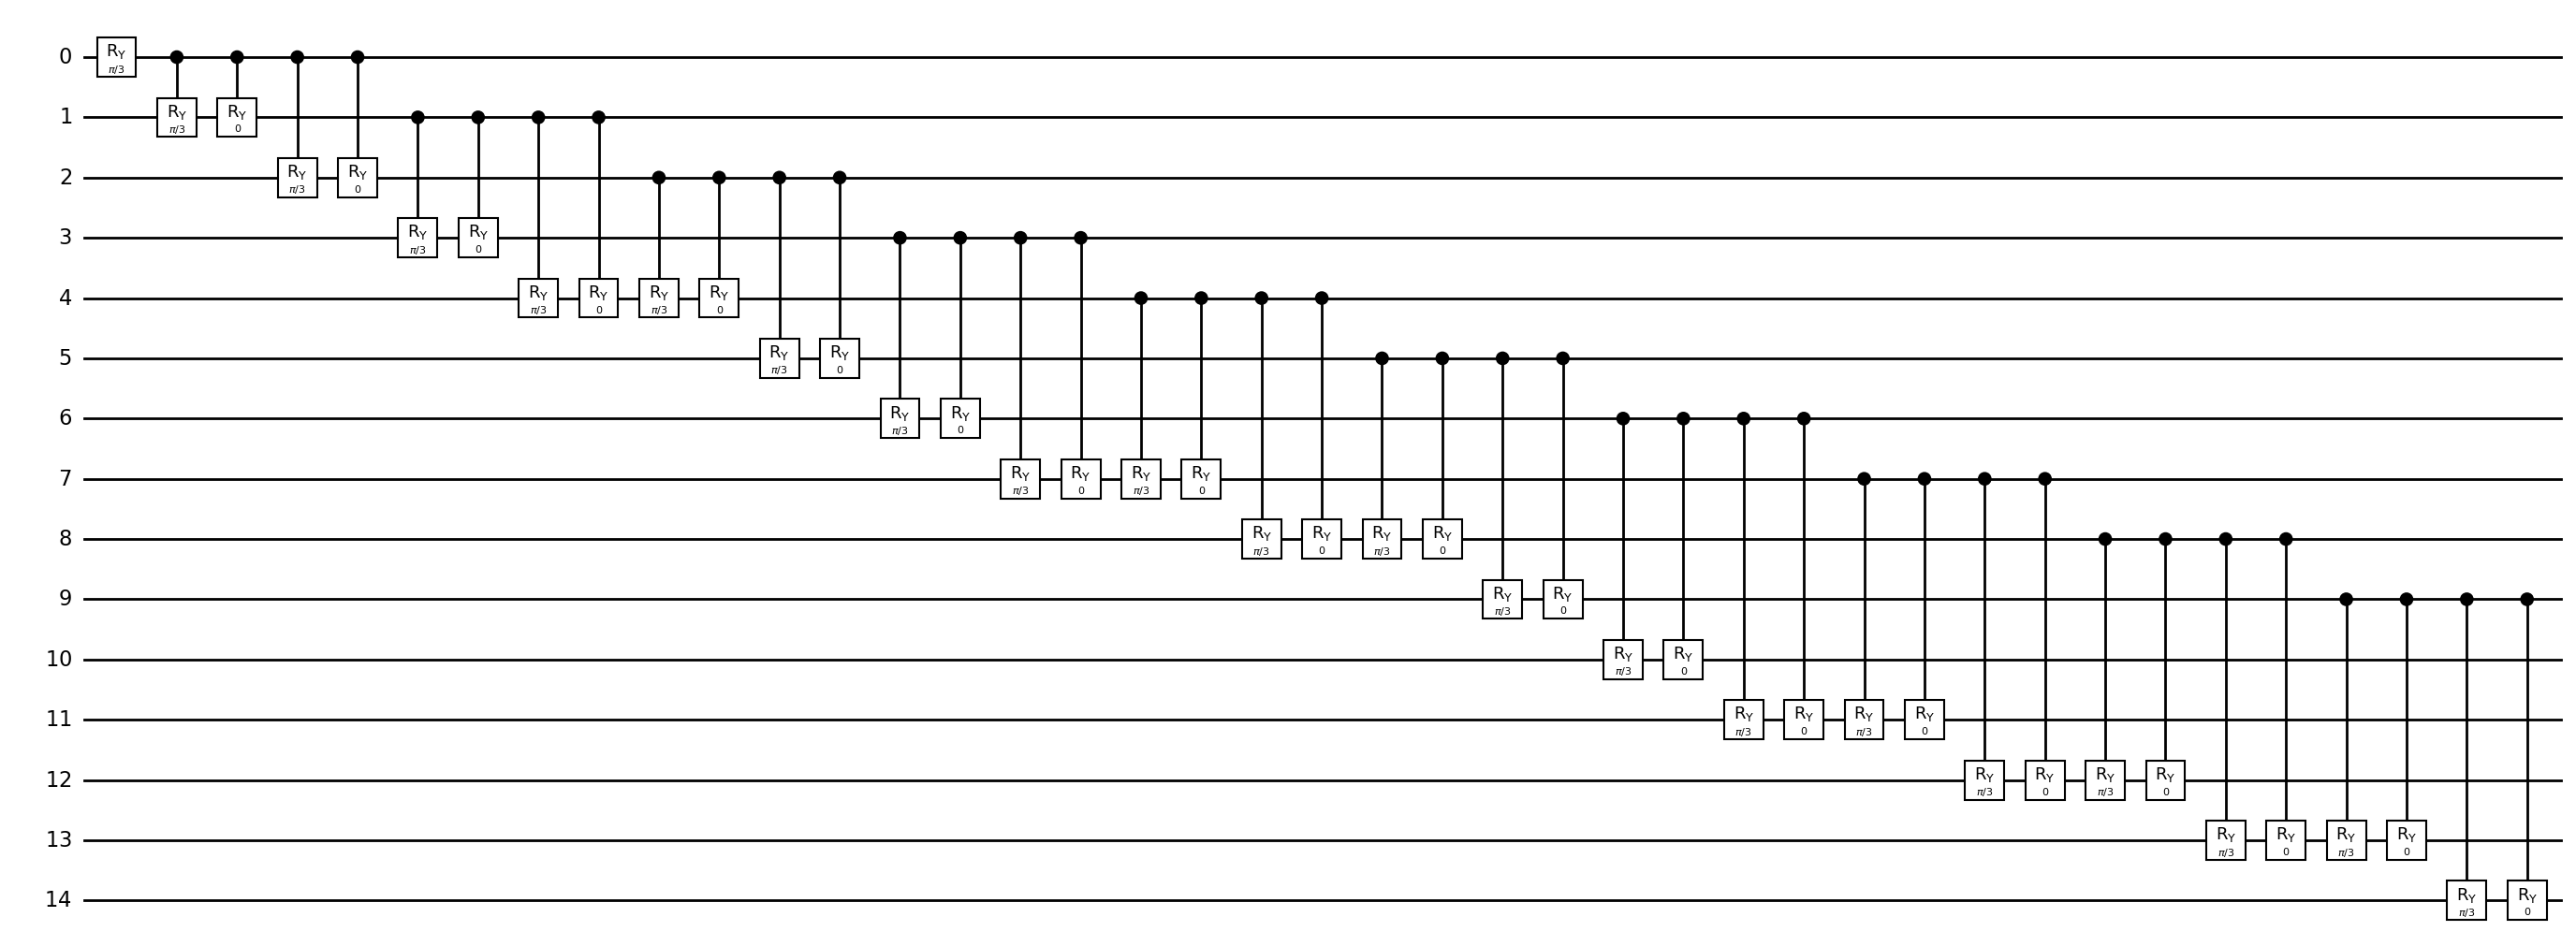

In [8]:
# Initialize  register with A=0, B=1, C=2, ...
qr = [QuantumRegister(1, name=str(i)) for i in range(15)]
qc_pac = QuantumCircuit(*qr, name='Pachinko')
# Angle for controlled-rotation gates
rotation_angle_0 = 2 * np.arcsin(0)
rotation_angle_1 = 2 * np.arcsin(1/2)
# Specify control qubits
c_qubits=list(range(10))+list(range(10))
c_qubits.sort()
# Specify target qubits
offset = 0
t_qubits = list()
for d in range(5):
    offset += d
    for i in range(d+1):
        if (i+offset) != 0:
            t_qubits.append(i+offset)
        if (i != 0) and (i != d):
            t_qubits.append(i+offset)
print(t_qubits)
# Apply controlled rotation gates with the specified angle
qc_pac.ry(rotation_angle_1, 0)
for cq, tq in zip(c_qubits, t_qubits):
    qc_pac.cry(rotation_angle_1, control_qubit=qr[cq], target_qubit=qr[tq])
    qc_pac.cry(rotation_angle_0, control_qubit=qr[cq], target_qubit=qr[tq])
    
# Draw circuit
qc_pac.draw('mpl', style='bw', plot_barriers=False, justify='none', fold=-1)

Assume that you have seen the ball at node E. Now inference the probability that the ball will land at node M.

In [9]:
query = {'12': 1}
evidence = {'4': 1}
# Initialize quantum bayesian inference framework
qbayesian = QBayesian(circuit=qc_pac)
# Inference
qbayesian.inference(query=query, evidence=evidence)

0.12777000000000002